**Enformer**, a novel model architecture combining enhancer and transformer concepts, has been developed to enhance gene expression and chromatin state predictions in humans and mice based on DNA sequences. This innovative approach utilizes transformers, which are deep learning models known for their significant advancements in natural language processing and recent applications in modeling short DNA sequences. Transformers employ attention layers to transform each position in the input sequence by calculating a weighted sum across representations from other positions. The attention weight between two positions relies on their current representation vectors and the distance between them, enabling the model to refine predictions at specific regions, such as the transcription start site (TSS), by gathering information from relevant elements like enhancers that regulate the gene. Unlike convolutional layers, which require numerous successive layers to reach distal elements due to their limited receptive field, transformer layers facilitate a more efficient information flow between distant elements. By employing transformer layers, the receptive field of the model has been significantly expanded, allowing it to capture distal regulatory elements up to 100 kb away. In comparison, previous state-of-the-art models, such as Basenji2 or ExPecto, only reach elements within a range of 20 kb. This increase in the receptive field is crucial as it substantially increases the number of relevant enhancers observed by the model, expanding from 47% (<20 kb) to 84% (<100 kb) based on estimations derived from high-confidence enhancer-gene pairs.

In the follwoing we indicate a representative example of observed and predicted genomic tracks (log10 scale) at CD44 gene locus located in the test-set region with high disagreement between Enformer and Basenji2 predictions (Methods). For each experiment, all three tracks share the same y axis.

###setup
1-It imports the TensorFlow library using the line import tensorflow as tf.

2-It checks whether a GPU `(Graphics Processing Unit)` is available for use by using the `tf.config.list_physical_devices('GPU')` function. If there is no GPU available, it will raise an assertion error with the message 'Start the colab kernel with `GPU: Runtime -> Change runtime type -> GPU'`. This ensures that the code will only run if a GPU is available.

3-It installs the kipoiseq library with `version 0.5.2` using the command !pip install `kipoiseq==0.5.2 --quiet > /dev/null`. The `!` symbol denotes a shell command, and the pip install command is used to install Python packages. The `--quiet` flag is used to suppress the installation output, and `> /dev/null `redirects the output to null so that it is not displayed.

4-There is a comment stating that the pyYAML error can be ignored. `PyYAML` is a YAML parser and emitter for Python, and this comment suggests that there might be an error related to the pyYAML library during the installation of kipoiseq. However, since it is only a comment, the code does not handle or resolve this error.

In [ ]:
import tensorflow as tf
# Make sure the GPU is enabled
assert tf.config.list_physical_devices('GPU'), 'Start the colab kernel with GPU: Runtime -> Change runtime type -> GPU'
!pip install kipoiseq==0.5.2 --quiet > /dev/null
# You can ignore the pyYAML error

###Libraries

Now we just set up the environment for using various libraries and modules in a Python program. Here's a breakdown of what the code does:

1. It imports the `tensorflow_hub` library using the line `import tensorflow_hub as hub`. This library provides a way to reuse pre-trained TensorFlow models.
2. It imports the `joblib` library, which is used for serialization and deserialization of Python objects.
3. It imports the `gzip` library, which provides tools for working with gzip-compressed files.
4. It imports the `kipoiseq` library, which is used for working with genomic sequences and intervals.
5. It imports the `Interval` class from `kipoiseq`. This class represents an interval on a genomic sequence.
6. It imports the `pyfaidx` library, which is used for working with indexed FASTA files containing genomic sequences.
7. It imports the `pandas` library, which provides data structures and data analysis tools.
8. It imports the `numpy` library, which is used for numerical computing in Python.
9. It imports the `matplotlib.pyplot` module, which is a plotting library for creating visualizations.
10. It imports the `matplotlib` library as `mpl`, which provides additional customization options for matplotlib plots.
11. It imports the `seaborn` library, which is a data visualization library based on matplotlib.

The next two lines `%matplotlib inline` and `%config InlineBackend.figure_format = 'retina'` are Jupyter Notebook magic commands. `%matplotlib inline` ensures that the matplotlib plots are displayed inline within the notebook, and `%config InlineBackend.figure_format = 'retina'` sets the figure format to 'retina', which improves the quality of the displayed plots on high-resolution screens.


In [ ]:
import tensorflow_hub as hub
import joblib
import gzip
import kipoiseq
from kipoiseq import Interval
import pyfaidx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

Here the author just defines several file paths used in a program. Here's an explanation of what each line does:

1. `transform_path`: This variable stores the path to a file named 'enformer.finetuned.SAD.robustscaler-PCA500-robustscaler.transform.pkl' in a Google Cloud Storage bucket with the prefix 'gs://'. The file appears to be a pickled object that contains transformation information for the Enformer model.
2. `model_path`: This variable stores the URL 'https://tfhub.dev/deepmind/enformer/1', which represents the path to a pre-trained Enformer model available on TensorFlow Hub. The model can be loaded using this URL.
3. `fasta_file`: This variable stores the path to a file named 'genome.fa' located at '/root/data/'. The file is a FASTA file containing genomic sequences.
4. `clinvar_vcf`: This variable stores the path to a file named 'clinvar.vcf.gz' located at '/root/data/'. The file appears to be a gzipped VCF (Variant Call Format) file containing genetic variant information.


In [ ]:
transform_path = 'gs://dm-enformer/models/enformer.finetuned.SAD.robustscaler-PCA500-robustscaler.transform.pkl'
model_path = 'https://tfhub.dev/deepmind/enformer/1'
fasta_file = '/root/data/genome.fa'
clinvar_vcf = '/root/data/clinvar.vcf.gz'

In this part:

1. It sets the variable `targets_txt` to the URL 'https://raw.githubusercontent.com/calico/basenji/master/manuscripts/cross2020/targets_human.txt'. This URL points to a text file containing targets from the Basenji2 dataset, specifically related to cross-species regulatory sequence activity prediction.
2. It uses the `pd.read_csv()` function from the pandas library to read the contents of the `targets_txt` file into a DataFrame object called `df_targets`. The `sep='\t'` parameter specifies that the file is tab-separated.
3. Finally, it uses the `head()` method on the `df_targets` DataFrame to display the first three rows of the DataFrame, providing a glimpse of the data.


In [ ]:
# Download targets from Basenji2 dataset
# Cite: Kelley et al Cross-species regulatory sequence activity prediction. PLoS Comput. Biol. 16, e1008050 (2020).
targets_txt = 'https://raw.githubusercontent.com/calico/basenji/master/manuscripts/cross2020/targets_human.txt'
df_targets = pd.read_csv(targets_txt, sep='\t')
df_targets.head(3)

,index,genome,identifier,file,clip,scale,sum_stat,description
0,0,0,ENCFF833POA,/home/drk/tillage/datasets/human/dnase/encode/...,32,2,mean,DNASE:cerebellum male adult (27 years) and mal...
1,1,0,ENCFF110QGM,/home/drk/tillage/datasets/human/dnase/encode/...,32,2,mean,DNASE:frontal cortex male adult (27 years) and...
2,2,0,ENCFF880MKD,/home/drk/tillage/datasets/human/dnase/encode/...,32,2,mean,DNASE:chorion


###Download files

1. `!mkdir -p /root/data`: This command creates a new directory named "data" in the "/root" directory. The `-p` option ensures that the command creates the directory only if it doesn't already exist.
2. `!wget -O - http://hgdownload.cse.ucsc.edu/goldenPath/hg38/bigZips/hg38.fa.gz | gunzip -c > {fasta_file}`: This command uses the `wget` command-line tool to download a gzipped FASTA file from the specified URL. The downloaded file is then piped into the `gunzip` command, which decompresses the file and sends the output to the specified `{fasta_file}` path. In other words, it downloads a gzipped FASTA file and saves it to the path stored in the `fasta_file` variable.
3. `pyfaidx.Faidx(fasta_file)`: This line creates a `Faidx` object from the `pyfaidx` library using the `fasta_file` path. The `Faidx` object allows for efficient random access to sequences in the FASTA file.
4. `!ls /root/data`: This command lists the files and directories in the "/root/data" directory, displaying them in the output.



In [ ]:
!mkdir -p /root/data
!wget -O - http://hgdownload.cse.ucsc.edu/goldenPath/hg38/bigZips/hg38.fa.gz | gunzip -c > {fasta_file}
pyfaidx.Faidx(fasta_file)
!ls /root/data

--2021-03-26 11:38:38--  http://hgdownload.cse.ucsc.edu/goldenPath/hg38/bigZips/hg38.fa.gz
Resolving hgdownload.cse.ucsc.edu (hgdownload.cse.ucsc.edu)... 128.114.119.163
Connecting to hgdownload.cse.ucsc.edu (hgdownload.cse.ucsc.edu)|128.114.119.163|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 983659424 (938M) [application/x-gzip]
Saving to: ‘STDOUT’

-                   100%[===================>] 938.09M  17.4MB/s    in 54s     

2021-03-26 11:39:33 (17.3 MB/s) - written to stdout [983659424/983659424]

genome.fa  genome.fa.fai


In [ ]:
!wget https://ftp.ncbi.nlm.nih.gov/pub/clinvar/vcf_GRCh38/clinvar.vcf.gz -O /root/data/clinvar.vcf.gz

--2021-03-26 11:40:32--  https://ftp.ncbi.nlm.nih.gov/pub/clinvar/vcf_GRCh38/clinvar.vcf.gz
Resolving ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)... 130.14.250.7, 165.112.9.229, 2607:f220:41e:250::7, ...
Connecting to ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)|130.14.250.7|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 36564426 (35M) [application/x-gzip]
Saving to: ‘/root/data/clinvar.vcf.gz’

/root/data/clinvar. 100%[===================>]  34.87M  22.0MB/s    in 1.6s    

2021-03-26 11:40:34 (22.0 MB/s) - ‘/root/data/clinvar.vcf.gz’ saved [36564426/36564426]



###Enformer
1. `SEQUENCE_LENGTH = 393216`: This line assigns the value 393216 to the variable `SEQUENCE_LENGTH`. It seems to define a constant value for the length of a sequence.

2. `class Enformer`: This line starts the definition of the `Enformer` class.

   - `def __init__(self, tfhub_url)`: This method is the constructor of the `Enformer` class. It takes a parameter `tfhub_url`, which represents the URL of the Enformer model to be loaded using TensorFlow Hub. Inside the constructor, the Enformer model is loaded using `hub.load(tfhub_url).model` and assigned to the `_model` attribute of the `Enformer` instance.

   - `def predict_on_batch(self, inputs)`: This method takes an `inputs` parameter and predicts the output for a batch of inputs using the loaded Enformer model. It calls `self._model.predict_on_batch(inputs)` to obtain the predictions and returns a dictionary of the predictions with the values converted to NumPy arrays.

   - `@tf.function`: This decorator is used to convert the following method into a TensorFlow graph for improved performance.

   - `def contribution_input_grad(self, input_sequence, target_mask, output_head='human')`: This method calculates the contribution of input sequence elements to the prediction output for a given target mask. It takes three parameters: `input_sequence`, `target_mask`, and `output_head`. It computes the contribution by using gradient tape to record the gradients with respect to the input sequence and then multiplying the gradient with the input sequence. The resulting tensor is reduced along the last axis and returned.


In [ ]:
SEQUENCE_LENGTH = 393216

class Enformer:

  def __init__(self, tfhub_url):
    self._model = hub.load(tfhub_url).model

  def predict_on_batch(self, inputs):
    predictions = self._model.predict_on_batch(inputs)
    return {k: v.numpy() for k, v in predictions.items()}

  @tf.function
  def contribution_input_grad(self, input_sequence,
                              target_mask, output_head='human'):
    input_sequence = input_sequence[tf.newaxis]

    target_mask_mass = tf.reduce_sum(target_mask)
    with tf.GradientTape() as tape:
      tape.watch(input_sequence)
      prediction = tf.reduce_sum(
          target_mask[tf.newaxis] *
          self._model.predict_on_batch(input_sequence)[output_head]) / target_mask_mass

    input_grad = tape.gradient(prediction, input_sequence) * input_sequence
    input_grad = tf.squeeze(input_grad, axis=0)
    return tf.reduce_sum(input_grad, axis=-1)


1. `class EnformerScoreVariantsRaw`: This line starts the definition of the `EnformerScoreVariantsRaw` class.

   - `def __init__(self, tfhub_url, organism='human')`: This method is the constructor of the `EnformerScoreVariantsRaw` class. It takes two parameters: `tfhub_url`, which represents the URL of the Enformer model to be loaded using TensorFlow Hub, and `organism` (with a default value of 'human'), which represents the organism for which the scores are being calculated. Inside the constructor, it creates an instance of the `Enformer` class (defined in the previous code snippet) using the provided `tfhub_url` and assigns it to the `_model` attribute of the `EnformerScoreVariantsRaw` instance. It also assigns the provided `organism` to the `_organism` attribute.

   - `def predict_on_batch(self, inputs)`: This method takes an `inputs` parameter, which is expected to be a dictionary containing 'ref' and 'alt' keys representing reference and alternative genetic sequences, respectively. It calculates the predictions for both the reference and alternative sequences using the `_model.predict_on_batch()` method of the `Enformer` instance, and extracts the predictions specific to the `_organism` attribute. It then computes the mean along the axis 1 for both the reference and alternative predictions and returns the difference between the mean values.


In [ ]:
class EnformerScoreVariantsRaw:

  def __init__(self, tfhub_url, organism='human'):
    self._model = Enformer(tfhub_url)
    self._organism = organism

  def predict_on_batch(self, inputs):
    ref_prediction = self._model.predict_on_batch(inputs['ref'])[self._organism]
    alt_prediction = self._model.predict_on_batch(inputs['alt'])[self._organism]

    return alt_prediction.mean(axis=1) - ref_prediction.mean(axis=1)



1. `EnformerScoreVariantsNormalized`:
   - This class takes four parameters in its constructor: `tfhub_url`, `transform_pkl_path`, `organism`, and `num_top_features`. However, it asserts that the `organism` parameter must be set to 'human' as the transforms used are only compatible with the human organism.
   - It creates an instance of the `EnformerScoreVariantsRaw` class (from the previous code snippet) using the provided `tfhub_url` and `organism` parameters and assigns it to the `_model` attribute.
   - It loads a transformation pipeline object from a pickle file located at `transform_pkl_path` using the `joblib.load()` function. The transformation pipeline likely consists of preprocessing steps applied to the scores obtained from the `_model` predictions.
   - The first step of the transformation pipeline is assumed to be a standard scaler (i.e., `StandardScaler`), and it is assigned to the `_transform` attribute for later use.
   - The `predict_on_batch()` method takes an `inputs` parameter and calculates the scores using the `_model.predict_on_batch()` method. It then applies the transformation pipeline to the scores using `_transform.transform()` and returns the transformed scores.

2. `EnformerScoreVariantsPCANormalized`:
   - This class takes five parameters in its constructor: `tfhub_url`, `transform_pkl_path`, `organism`, and `num_top_features`.
   - It creates an instance of the `EnformerScoreVariantsRaw` class (from the previous code snippet) using the provided `tfhub_url` and `organism` parameters and assigns it to the `_model` attribute.
   - It loads a transformation object (likely PCA transformation) from a pickle file located at `transform_pkl_path` using the `joblib.load()` function and assigns it to the `_transform` attribute.
   - The `predict_on_batch()` method takes an `inputs` parameter and calculates the scores using the `_model.predict_on_batch()` method. It then applies the transformation object to the scores using `_transform.transform()` and selects only the top `num_top_features` columns of the transformed scores before returning the result.

In summary, these classes extend the functionality of the `Enformer` class by applying additional transformations to the raw scores predicted by the model. The `EnformerScoreVariantsNormalized` class applies a standard scaling transformation, while the `EnformerScoreVariantsPCANormalized` class applies a PCA transformation and selects a subset of the transformed features.

In [ ]:
class EnformerScoreVariantsNormalized:

  def __init__(self, tfhub_url, transform_pkl_path,
               organism='human'):
    assert organism == 'human', 'Transforms only compatible with organism=human'
    self._model = EnformerScoreVariantsRaw(tfhub_url, organism)
    with tf.io.gfile.GFile(transform_pkl_path, 'rb') as f:
      transform_pipeline = joblib.load(f)
    self._transform = transform_pipeline.steps[0][1]  # StandardScaler.

  def predict_on_batch(self, inputs):
    scores = self._model.predict_on_batch(inputs)
    return self._transform.transform(scores)


class EnformerScoreVariantsPCANormalized:

  def __init__(self, tfhub_url, transform_pkl_path,
               organism='human', num_top_features=500):
    self._model = EnformerScoreVariantsRaw(tfhub_url, organism)
    with tf.io.gfile.GFile(transform_pkl_path, 'rb') as f:
      self._transform = joblib.load(f)
    self._num_top_features = num_top_features

  def predict_on_batch(self, inputs):
    scores = self._model.predict_on_batch(inputs)
    return self._transform.transform(scores)[:, :self._num_top_features]

In this part the author defined a function called `variant_centered_sequences` and some auxiliary classes and functions. Here's a breakdown of what each part of the code does:

1. `class FastaStringExtractor`:
   - This class is used to extract DNA sequences from a FASTA file.
   - The constructor takes a `fasta_file` parameter, which represents the path to the FASTA file.
   - It initializes a `pyfaidx.Fasta` object to read the FASTA file and stores the chromosome sizes in the `_chromosome_sizes` attribute.

2. `def extract(self, interval: Interval, **kwargs) -> str`:
   - This method extracts the DNA sequence for a given interval from the FASTA file.
   - It takes an `interval` parameter of type `Interval`, which represents the genomic interval to extract.
   - The method trims the interval to ensure it doesn't extend beyond the chromosome lengths.
   - It uses the `pyfaidx.Fasta.get_seq()` method to retrieve the sequence for the trimmed interval from the FASTA file.
   - It pads the sequence with 'N' characters to fill truncated values before returning the extracted sequence.

3. `def variant_generator(vcf_file, gzipped=False)`:
   - This function is a generator that yields `kipoiseq.dataclasses.Variant` objects for each row in a VCF (Variant Call Format) file.
   - It takes a `vcf_file` parameter representing the path to the VCF file and an optional `gzipped` parameter indicating whether the file is gzipped.
   - The function opens the VCF file and iterates over its lines, skipping lines starting with '#'.
   - For each non-header line, it extracts the chromosome, position, ID, reference allele, and alternate alleles.
   - It splits the alternate alleles and yields a `kipoiseq.dataclasses.Variant` object for each alternate allele, with the relevant information.

4. `def one_hot_encode(sequence)`:
   - This function performs one-hot encoding on a DNA sequence.
   - It takes a `sequence` parameter representing the DNA sequence as a string.
   - It uses `kipoiseq.transforms.functional.one_hot_dna()` to convert the sequence into a one-hot encoded representation, where each base is represented by a one-hot vector.
   - The resulting one-hot encoded sequence is cast to `np.float32` and returned.

5. `def variant_centered_sequences(vcf_file, sequence_length, gzipped=False, chr_prefix='')`:
   - This function generates variant-centered sequences for each variant in a VCF file.
   - It takes a `vcf_file` parameter representing the path to the VCF file, a `sequence_length` parameter specifying the desired length of the sequences, and optional parameters `gzipped` and `chr_prefix`.
   - It initializes a `VariantSeqExtractor` object from `kipoiseq.extractors` with a `FastaStringExtractor` object as the reference sequence extractor.
   - It iterates over variants generated by the `variant_generator` function.
   - For each variant, it constructs an interval around the variant position with a specified length (`sequence_length`).
   - It uses the `seq_extractor` to extract reference and alternate sequences centered around the variant.
   - It one-hot encodes the reference and alternate sequences using the `one_hot_encode` function.
   - It yields a dictionary with the one-hot encoded sequences (`'ref'` and `'alt'`) as inputs and metadata about the variant (chromosome, position, ID, reference allele, and alternate allele).

In summary, the `variant_centered_sequences` function generates variant-centered DNA sequences for each variant in a V



In [ ]:
class FastaStringExtractor:

    def __init__(self, fasta_file):
        self.fasta = pyfaidx.Fasta(fasta_file)
        self._chromosome_sizes = {k: len(v) for k, v in self.fasta.items()}

    def extract(self, interval: Interval, **kwargs) -> str:
        # Truncate interval if it extends beyond the chromosome lengths.
        chromosome_length = self._chromosome_sizes[interval.chrom]
        trimmed_interval = Interval(interval.chrom,
                                    max(interval.start, 0),
                                    min(interval.end, chromosome_length),
                                    )
        # pyfaidx wants a 1-based interval
        sequence = str(self.fasta.get_seq(trimmed_interval.chrom,
                                          trimmed_interval.start + 1,
                                          trimmed_interval.stop).seq).upper()
        # Fill truncated values with N's.
        pad_upstream = 'N' * max(-interval.start, 0)
        pad_downstream = 'N' * max(interval.end - chromosome_length, 0)
        return pad_upstream + sequence + pad_downstream

    def close(self):
        return self.fasta.close()


def variant_generator(vcf_file, gzipped=False):
  """Yields a kipoiseq.dataclasses.Variant for each row in VCF file."""
  def _open(file):
    return gzip.open(vcf_file, 'rt') if gzipped else open(vcf_file)

  with _open(vcf_file) as f:
    for line in f:
      if line.startswith('#'):
        continue
      chrom, pos, id, ref, alt_list = line.split('\t')[:5]
      # Split ALT alleles and return individual variants as output.
      for alt in alt_list.split(','):
        yield kipoiseq.dataclasses.Variant(chrom=chrom, pos=pos,
                                           ref=ref, alt=alt, id=id)


def one_hot_encode(sequence):
  return kipoiseq.transforms.functional.one_hot_dna(sequence).astype(np.float32)


def variant_centered_sequences(vcf_file, sequence_length, gzipped=False,
                               chr_prefix=''):
  seq_extractor = kipoiseq.extractors.VariantSeqExtractor(
    reference_sequence=FastaStringExtractor(fasta_file))

  for variant in variant_generator(vcf_file, gzipped=gzipped):
    interval = Interval(chr_prefix + variant.chrom,
                        variant.pos, variant.pos)
    interval = interval.resize(sequence_length)
    center = interval.center() - interval.start

    reference = seq_extractor.extract(interval, [], anchor=center)
    alternate = seq_extractor.extract(interval, [variant], anchor=center)

    yield {'inputs': {'ref': one_hot_encode(reference),
                      'alt': one_hot_encode(alternate)},
           'metadata': {'chrom': chr_prefix + variant.chrom,
                        'pos': variant.pos,
                        'id': variant.id,
                        'ref': variant.ref,
                        'alt': variant.alt}}

###Function for ploting the plots

In [ ]:
def plot_tracks(tracks, interval, height=1.5):
  fig, axes = plt.subplots(len(tracks), 1, figsize=(20, height * len(tracks)), sharex=True)
  for ax, (title, y) in zip(axes, tracks.items()):
    ax.fill_between(np.linspace(interval.start, interval.end, num=len(y)), y)
    ax.set_title(title)
    sns.despine(top=True, right=True, bottom=True)
  ax.set_xlabel(str(interval))
  plt.tight_layout()

### Resutl of prediction and comparing
In the following we have purpose of:
- Make predictions for a genetic sequenece
- Make predictions for an genomic example interval
to do so we will:

1. Create an instance of the `Enformer` class using the `model_path` as the model URL.
2. Create an instance of the `FastaStringExtractor` class using the `fasta_file` as the FASTA file path.
3. Define a `target_interval` using the `kipoiseq.Interval` class with chromosome 11 and specific start and end positions.
4. Extract the DNA sequence from the `target_interval` using the `fasta_extractor.extract()` method. The sequence is then resized to the `SEQUENCE_LENGTH`.
5. Perform one-hot encoding on the extracted sequence using the `one_hot_encode` function.
6. Make predictions on the one-hot encoded sequence by calling the `model.predict_on_batch()` method, passing the sequence as input. The predictions are obtained for the `'human'` output head.
7. Create a dictionary `tracks` that contains specific tracks and their corresponding predictions from the model.
   - `'DNASE:CD14-positive monocyte female'`: predictions for track 41.
   - `'DNASE:keratinocyte female'`: predictions for track 42.
   - `'CHIP:H3K27ac:keratinocyte female'`: predictions for track 706.
   - `'CAGE:Keratinocyte - epidermal'`: logarithmically transformed predictions for track 4799.
8. Plot the tracks using the `plot_tracks()` function, passing the `tracks` dictionary and the `target_interval` as arguments.

Overall, this code uses the `Enformer` model to predict tracks for a specific target interval in the genome, and then visualizes these tracks using the `plot_tracks()` function.

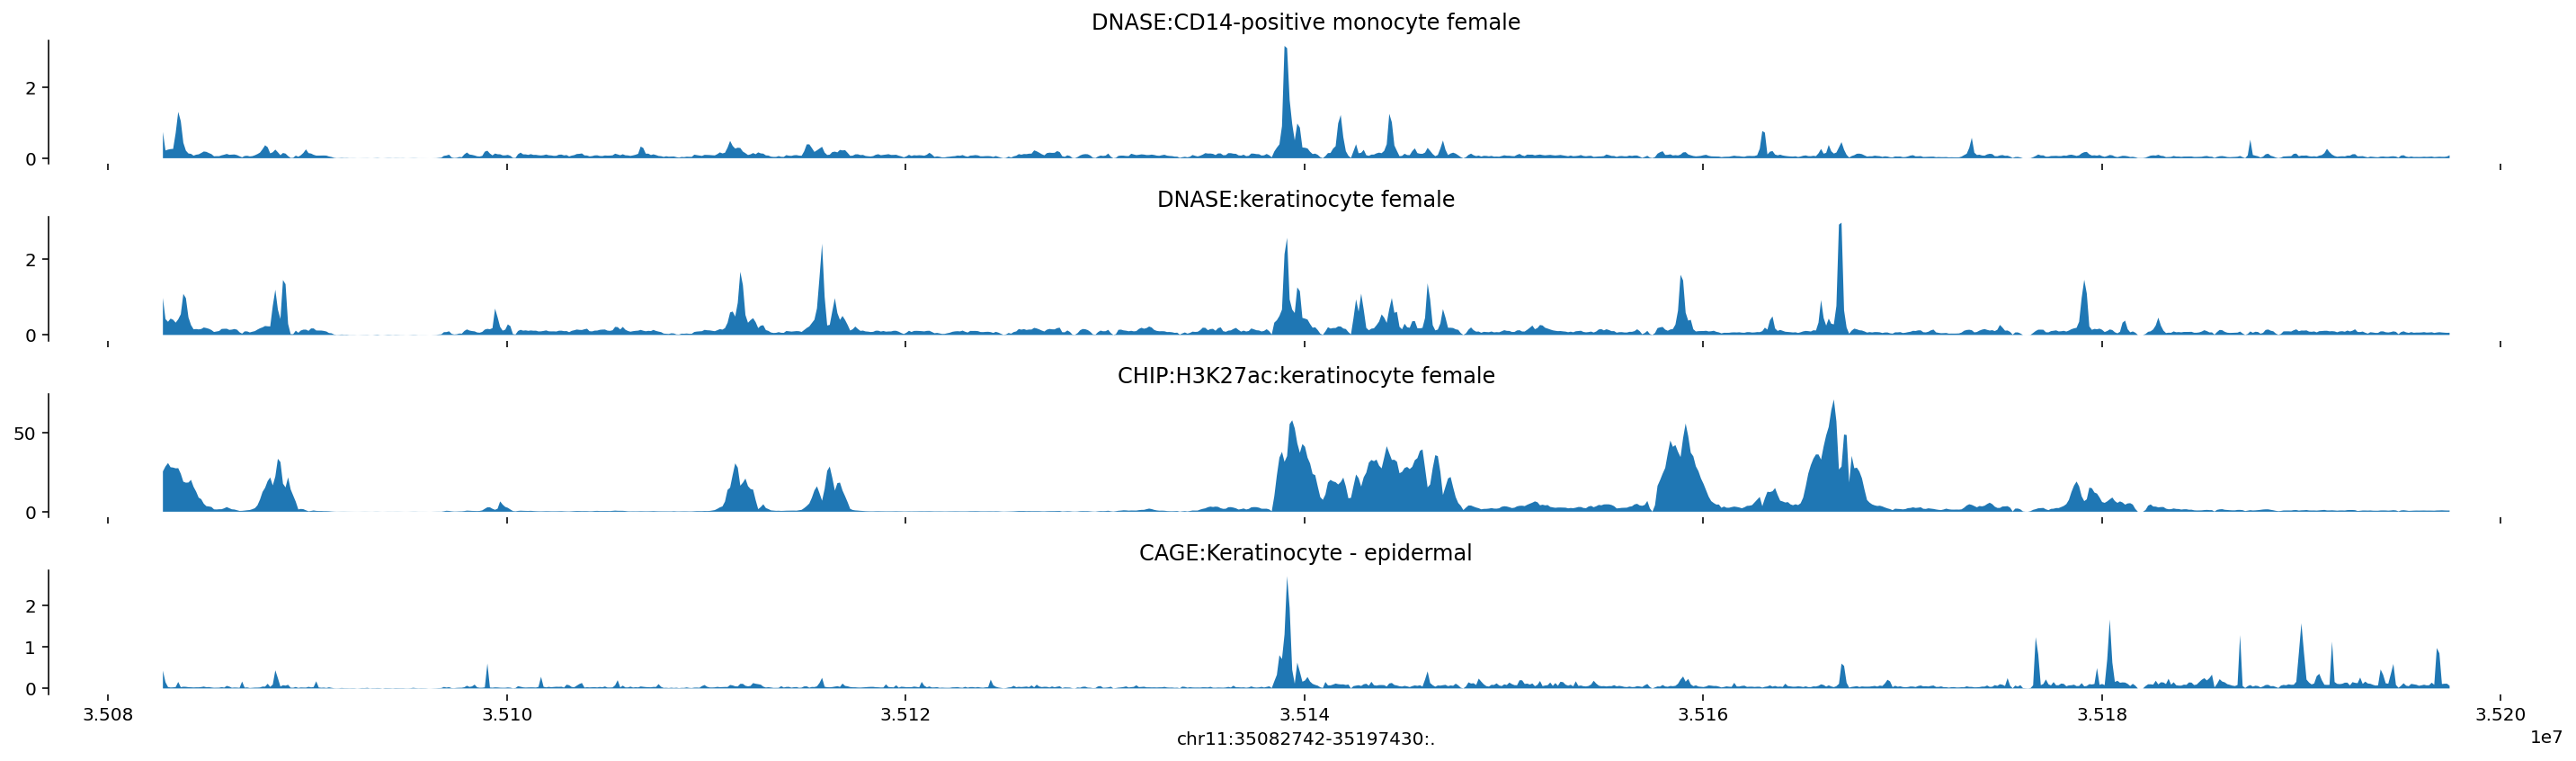

In [ ]:
model = Enformer(model_path)

fasta_extractor = FastaStringExtractor(fasta_file)

target_interval = kipoiseq.Interval('chr11', 35_082_742, 35_197_430)  # @param

sequence_one_hot = one_hot_encode(fasta_extractor.extract(target_interval.resize(SEQUENCE_LENGTH)))
predictions = model.predict_on_batch(sequence_one_hot[np.newaxis])['human'][0]
tracks = {'DNASE:CD14-positive monocyte female': predictions[:, 41],
          'DNASE:keratinocyte female': predictions[:, 42],
          'CHIP:H3K27ac:keratinocyte female': predictions[:, 706],
          'CAGE:Keratinocyte - epidermal': np.log10(1 + predictions[:, 4799])}
plot_tracks(tracks, target_interval)

Enformer, an advanced model architecture, focuses on cell-type-specific enhancers to improve gene expression prediction. In order to gain insights into the specific sequence elements that Enformer utilizes during its predictions, we calculated two different scores that contribute to gene expression: input gradients (gradient × input) and attention weights. These scores highlight the input sequences that have the highest predictive value for the expression of a particular gene.

The input gradients and in silico mutagenesis scores are specific to the tissue or cell type being considered, as they are computed with respect to a particular output CAGE sample (e.g., K562). On the other hand, attention weights are internal to the model and are shared across all tissue and cell type predictions.

Upon analyzing the contribution scores of several genes, we observed a correlation between these scores and the presence of histone H3 acetylated at K27 (H3K27ac). Furthermore, the contribution scores not only highlighted local promoter regions but also emphasized distal enhancers located more than 20 kb away from the transcription start site (TSS). This is in contrast to Basenji2, whose contribution scores for sequences beyond 20 kb from the TSS were zero due to its limited receptive field, causing it to miss out on several enhancers.

This example illustrates that Enformer effectively considers biologically relevant regions, including enhancers that are located beyond 20 kb, when making predictions. The gene expression contribution scores obtained from Enformer can be valuable in prioritizing and identifying relevant enhancers for further analysis.

###Track Visualization:

In this step the author visualizes contribution scores for a specific target interval within a DNA sequence.

Here's a breakdown of what the code does:

1. Defines the target interval on chromosome 12 with start and end positions specified.
2. Extracts the DNA sequence corresponding to the target interval and converts it to a one-hot encoded representation.
3. Uses the Enformer model to make predictions on the one-hot encoded sequence. The predictions are specifically for the 'human' output.
4. Creates a target mask, initially filled with zeros, to identify specific positions in the predictions for which contribution scores will be computed.
5. Sets certain positions in the target mask to 1. In this case, the positions [447, 448, 449] in the target mask are selected, and the corresponding indices [4828, 5111] in the predictions are set to 1.
6. Computes the contribution scores using the `contribution_input_grad` method of the Enformer model. This method calculates the gradient of the model's prediction with respect to the input sequence, multiplied by the input sequence. The resulting contribution scores represent the importance of each position in the sequence for the specified target positions.
7. Performs average pooling on the absolute values of the contribution scores using a window size of 128 and a stride of 128. This reduces the resolution of the contribution scores while capturing the overall trends.
8. Extracts the relevant portion of the pooled contribution scores, excluding the boundary regions.
9. Constructs tracks for visualization, including 'CAGE predictions' (values from the predictions at index 4828) and 'Enformer gradient*input' (contribution scores limited to a maximum value of 0.03).
10. Calls the `plot_tracks` function to visualize the tracks on a graph, representing the CAGE predictions and the contribution scores derived from the gradient times input.

Please note that the code assumes the existence of the `plot_tracks` function, which is not provided in the code snippet, so its specific implementation and output are not shown here.

In [ ]:
target_interval = kipoiseq.Interval('chr12', 54_223_589, 54_338_277)  # @param

sequence_one_hot = one_hot_encode(fasta_extractor.extract(target_interval.resize(SEQUENCE_LENGTH)))
predictions = model.predict_on_batch(sequence_one_hot[np.newaxis])['human'][0]

target_mask = np.zeros_like(predictions)
for idx in [447, 448, 449]:
  target_mask[idx, 4828] = 1
  target_mask[idx, 5111] = 1
# This will take some time since tf.function needs to get compiled.
contribution_scores = model.contribution_input_grad(sequence_one_hot.astype(np.float32), target_mask).numpy()
pooled_contribution_scores = tf.nn.avg_pool1d(np.abs(contribution_scores)[np.newaxis, :, np.newaxis], 128, 128, 'VALID')[0, :, 0].numpy()[1088:-1088]

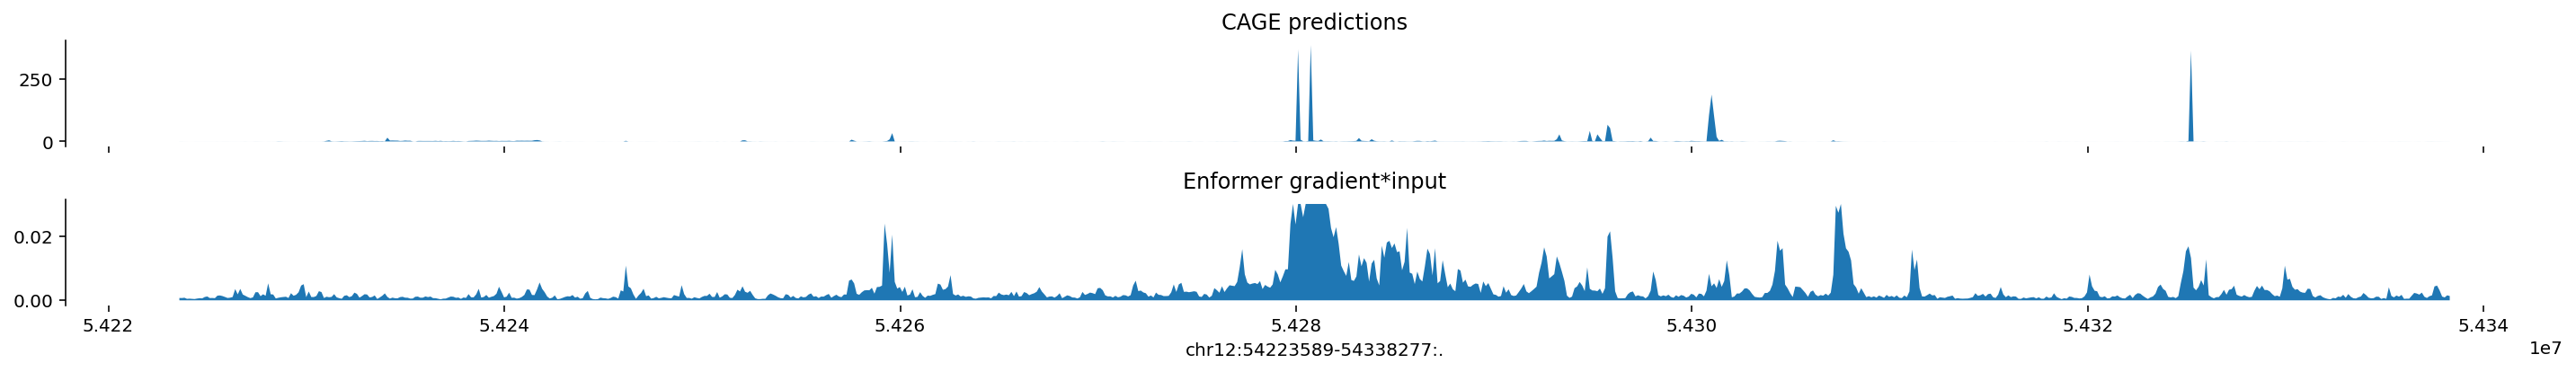

In [ ]:
tracks = {'CAGE predictions': predictions[:, 4828],
          'Enformer gradient*input': np.minimum(pooled_contribution_scores, 0.03)}
plot_tracks(tracks, target_interval);

 HNRNPA1 locus showing: predicted CAGE expression in K562; measured H3K27ac highlighting active enhancers; candidate and CRISPRi-validated enhancers exhibiting significant HNRNPA1 expression changes from Fulco et al.13; enformer attention weight averaged across all layers and heads for a query placed at the main TSS of HNRNPA1 gene (position 0).